In [13]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ, assemble
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.interpolate import CubicSpline

# start process the data----------------------------------------------------------------
file_1 = 'NbN_1.txt'
file_2 = 'NbN_2.txt'
# Load file as array: digits
data_1 = np.loadtxt(file_1, delimiter=',', skiprows = 1)
data_2 = np.loadtxt(file_2, delimiter=',', skiprows = 1)
# interpolate data_1
x_1 = data_1[:,0]
y_1 = data_1[:,1]
cs_1 = CubicSpline(x_1, y_1) # a function
xs_1 = np.arange(0, 360, 0.001)
# interpolate data_2
x_2 = data_2[:,0]
y_2 = data_2[:,1]
cs_2 = CubicSpline(x_2, y_2) # a function
xs_2 = np.arange(0, 360, 0.001)

# done process the data----------------------------------------------------------------

# Set backend device, choose to use a simulator
sim = Aer.get_backend('aer_simulator')


# functions..............................................................................................

def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one circuit for each value of theta in theta_vec)
    (theta is the angle between the bases of Alice and Bob)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    all_theta_0and1 = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11'] # observed_vector ex: '01' means 1st measurement got 0, second got 1
        for el in obs_vec:
            qc = QuantumCircuit(2,2) # create a quantum circuit with two quantum register(qubits) and two classical register
            qc.h(0) # add a H gate on qubit 0
            qc.cx(0, 1) # Add a CX (CNOT) gate on control qubit 0 and target qubit 1
            qc.ry(theta, 0) # rotate around y-axis by theta
            for a in range(2): # what does this do? why do we need this part?
                if el[a] == '1':
                    qc.h(a)
                    
            # show statevector
            qc.save_statevector()
            qobj = assemble(qc)
            final_state = sim.run(qobj).result().get_statevector()
            
            # use final_state, find theta_0 and theta_1
            theta_0and1 = []
            theta_0 = np.arctan((np.absolute(final_state[1])/np.absolute(final_state[0]))**2)*180/np.pi
            if(final_state[2]==0):
                theta_1 = 90
            else:
                theta_1 = np.arctan((np.absolute(final_state[3])/np.absolute(final_state[2]))**2)*180/np.pi
            round_theta0 = np.round(theta_0,4)
            round_theta1 = np.round(theta_1,4)
            theta_0and1.append(round_theta0)
            theta_0and1.append(round_theta1)
            
            all_theta_0and1.append(theta_0and1)
    
            qc.measure(range(2),range(2)) # measure q0 save to bit_0, then measure q1 save to bit_1
            chsh_circuits.append(qc)
            
    return chsh_circuits, all_theta_0and1

def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0] # alice uses z basis, bob uses z basis, which is the same as a and b measurement.
        zx = theta_dict[1] # a and b'
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = num_of_shots

        chsh1 = 0

        # E(a,b)
        for element in zz:  # zz is a dict
            parity = (-1)**(int(element[0])+int(element[1])) # plus for N_00, N_11; minus for N_01, N_10
            chsh1+= parity*zz[element]

        #E(a,b')
        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*zx[element]

        #E(a',b)
        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xz[element]

        # E(a',b')
        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
    
    return CHSH1 #return the S of each circuit

def use_snspd_data(Counts_ideal):
    Counts_snspd = []
    for i in range(0,len(Counts_ideal)):
        temp_dict = {}
        if ('00' in Counts_ideal[i]) == False:
            Counts_ideal[i]['00'] = 0
        if ('01' in Counts_ideal[i]) == False:
            Counts_ideal[i]['01'] = 0
        if ('10' in Counts_ideal[i]) == False:
            Counts_ideal[i]['10'] = 0
        if ('11' in Counts_ideal[i]) == False:
            Counts_ideal[i]['11'] = 0
        temp_dict['00'] = 0.9*(Counts_ideal[i]['00'] + Counts_ideal[i]['01'])*cs_2(results_of_qc[1][i][0])
        temp_dict['01'] = 0.9*(Counts_ideal[i]['00'] + Counts_ideal[i]['01'])*cs_1(results_of_qc[1][i][0])
        temp_dict['10'] = 0.9*(Counts_ideal[i]['10'] + Counts_ideal[i]['11'])*cs_2(results_of_qc[1][i][1])
        temp_dict['11'] = 0.9*(Counts_ideal[i]['10'] + Counts_ideal[i]['11'])*cs_1(results_of_qc[1][i][1])
        Counts_snspd.append(temp_dict)
        
    return Counts_snspd

# functions...........................................................................................

#split 0 to 2pi into 15 angles. use these angles to build the chsh circuit
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
results_of_qc = make_chsh_circuit(theta_vec)
my_chsh_circuits = results_of_qc[0]



In [14]:
# Execute and get counts
num_of_shots = 10000
result_ideal = sim.run(my_chsh_circuits, shots=num_of_shots).result()
counts_ideal = result_ideal.get_counts()
counts_snspd = use_snspd_data(counts_ideal)
CHSH1_ideal = compute_chsh_witness(counts_ideal) # this is the ideal S value
CHSH1_snspd = compute_chsh_witness(counts_snspd)

# print(counts_ideal)
# print("-----------------")
# print(counts_snspd)
for i in range(23,27):
    print(counts_ideal[i])
    print(counts_snspd[i])
    print((counts_snspd[i]['00']-counts_snspd[i]['01']-counts_snspd[i]['10']+counts_snspd[i]['11'])/num_of_shots)
    print((counts_ideal[i]['00']-counts_ideal[i]['01']-counts_ideal[i]['10']+counts_ideal[i]['11'])/num_of_shots)
    print((counts_snspd[i]['00']+counts_snspd[i]['01']+counts_snspd[i]['10']+counts_snspd[i]['11']))
    print((counts_ideal[i]['00']+counts_ideal[i]['01']+counts_ideal[i]['10']+counts_ideal[i]['11']))
    print(num_of_shots)



{'01': 3999, '00': 928, '10': 4102, '11': 971}
{'00': 657.4116497426721, '01': 3445.59205035307, '10': 3610.5804151592065, '11': 214.4149452087904}
-0.6184345870560815
-0.6202
7927.999060463739
10000
10000
{'11': 258, '00': 218, '10': 4708, '01': 4816}
{'00': 516.3467344002906, '01': 3696.7560529314537, '10': 3688.9976481950007, '11': 34.21035529085693}
-0.6835196611435307
-0.9048
7936.310790817602
10000
10000
{'11': 1403, '00': 1455, '10': 3586, '01': 3556}
{'00': 938.9727593830181, '01': 3197.0951786544533, '10': 3281.5374023315953, '11': 516.8785626869517}
-0.5022781258916078
-0.4284
7934.483903056018
10000
10000
{'11': 3555, '01': 1447, '10': 1385, '00': 3613}
{'00': 3328.2379747039226, '01': 524.2344211657597, '10': 925.668615316725, '11': 3151.796085123328}
0.5030131023344766
0.4336
7929.937096309735
10000
10000


[1.99, 2.6568, 2.802, 2.4068, 1.523, 0.3304, -0.9322, -2.0058, -2.6714, -2.8206, -2.3888, -1.5146, -0.3116, 0.9136, 1.972]
[1.3756236207786001, 2.3719286089290237, 2.570773711681366, 1.9594238667394366, 0.7911379422713258, 0.09763598397201295, -0.3624356575048672, -1.3753732083408, -2.3714569842485784, -2.5706503541116623, -1.9577640855244496, -0.7934170590929782, -0.09922102627686905, 0.36447752637434394, 1.3769400843855002]


Text(0, 0.5, 'S value')

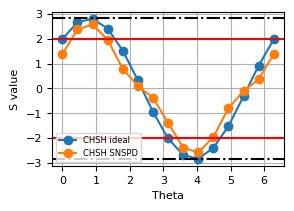

In [15]:
print(CHSH1_ideal)
print(CHSH1_snspd)

# make plot
plt.figure(figsize=(3,2))
plt.rcParams.update({'font.size': 8})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH ideal')
plt.plot(theta_vec,CHSH1_snspd,'o-',label = 'CHSH SNSPD')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 6})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('S value')

In [16]:
print(max(CHSH1_snspd))
print(min(CHSH1_snspd))


2.570773711681366
-2.5706503541116623
